## This code takes the combined NHANES data and makes some visuals and combines the data into a set that includes old versus new obesity classifications

### Load libraries and data

In [1]:
# Load Filtered Dataset
# ------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
file_name = "combinedNHANES.csv"  # Updated filename
filtered_data = pd.read_csv(file_name)

# Confirm the dataset was loaded successfully
print(f"Dataset loaded with shape: {filtered_data.shape}")
print("Columns in the dataset:\n", filtered_data.columns)
filtered_data.head()

Dataset loaded with shape: (33712, 15)
Columns in the dataset:
 Index(['Participant_ID', 'Age', 'Gender', 'Race_Ethnicity', 'BMI', 'Waist',
       'Fat_Free_Mass_kg', 'Total_Fat_Mass_kg', 'Percent_Fat',
       'Fasting_Glucose_mg_dL', 'HDL_Cholesterol_mg_dL',
       'Total_Cholesterol_mg_dL', 'Triglycerides_mg_dL', 'Systolic_BP_1',
       'Diastolic_BP_1'],
      dtype='object')


,Participant_ID,Age,Gender,Race_Ethnicity,BMI,Waist,Fat_Free_Mass_kg,Total_Fat_Mass_kg,Percent_Fat,Fasting_Glucose_mg_dL,HDL_Cholesterol_mg_dL,Total_Cholesterol_mg_dL,Triglycerides_mg_dL,Systolic_BP_1,Diastolic_BP_1
0,31130.0,85.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31131.0,44.0,2.0,4.0,30.9,96.0,4620.6,2233.6,48.3,90.0,39.0,105.0,86.0,144.0,74.0
2,31131.0,44.0,2.0,4.0,30.9,96.0,4620.6,2233.6,48.3,90.0,39.0,105.0,86.0,144.0,74.0
3,31131.0,44.0,2.0,4.0,30.9,96.0,4620.6,2233.6,48.3,90.0,39.0,105.0,86.0,144.0,74.0
4,31131.0,44.0,2.0,4.0,30.9,96.0,4620.6,2233.6,48.3,90.0,39.0,105.0,86.0,144.0,74.0


### Just in case I have a duplicate BMI, remove it

In [2]:
# Identify and drop the second BMI column if duplicates exist
if "BMI" in filtered_data.columns:
    bmi_columns = [col for col in filtered_data.columns if col == "BMI"]
    if len(bmi_columns) > 1:
        filtered_data = filtered_data.loc[:, ~filtered_data.columns.duplicated()]
        print("Dropped the second 'BMI' column.")
    else:
        print("Only one 'BMI' column exists; no duplicates to drop.")
print(filtered_data.columns)

Only one 'BMI' column exists; no duplicates to drop.
Index(['Participant_ID', 'Age', 'Gender', 'Race_Ethnicity', 'BMI', 'Waist',
       'Fat_Free_Mass_kg', 'Total_Fat_Mass_kg', 'Percent_Fat',
       'Fasting_Glucose_mg_dL', 'HDL_Cholesterol_mg_dL',
       'Total_Cholesterol_mg_dL', 'Triglycerides_mg_dL', 'Systolic_BP_1',
       'Diastolic_BP_1'],
      dtype='object')


### Classifications

In [3]:
import pandas as pd

# Define Clinical Obesity (Lancet definition)
def classify_clinical_obesity(row):
    bmi = row.get("BMI", None)
    waist = row.get("Waist", None)
    gender = row.get("Gender", None)
    systolic_bp = row.get("Systolic_BP_1", None)
    diastolic_bp = row.get("Diastolic_BP_1", None)
    fasting_glucose = row.get("Fasting_Glucose_mg_dL", None)
    triglycerides = row.get("Triglycerides_mg_dL", None)
    hdl = row.get("HDL_Cholesterol_mg_dL", None)

    # **Ensure valid values exist before proceeding**
    if pd.isnull(bmi) or pd.isnull(waist) or pd.isnull(gender):
        return "Unclassifiable (Missing Data)"

    # **Step 1: Strictly enforce BMI ≥ 30 first**
    if bmi < 30:
        return "No Clinical Obesity"

    # **Step 2: Apply waist condition based on gender**
    has_excess_fat = ((gender == 1 and waist >= 102) or (gender == 2 and waist >= 88))

    # **Ensure Clinical Obesity is only considered if excess adiposity is present**
    if not has_excess_fat:
        return "No Clinical Obesity"

    # **Step 3: Check for Dysfunction (Metabolic Syndrome Markers)**
    has_hypertension = (
        pd.notnull(systolic_bp) and pd.notnull(diastolic_bp) and
        (systolic_bp >= 140 or diastolic_bp >= 90)
    )
    
    has_diabetes = (
        pd.notnull(fasting_glucose) and fasting_glucose >= 126
    )
    
    has_dyslipidemia = (
        (pd.notnull(triglycerides) and triglycerides >= 150) or
        ((gender == 1 and pd.notnull(hdl) and hdl < 40) or 
         (gender == 2 and pd.notnull(hdl) and hdl < 50))
    )

    # **Final Classification**
    if has_hypertension or has_diabetes or has_dyslipidemia:
        return "Clinical Obesity"

    return "No Clinical Obesity"

# Define Preclinical Obesity (Lancet definition)
def classify_preclinical_obesity(row):
    bmi = row.get("BMI", None)
    waist = row.get("Waist", None)
    gender = row.get("Gender", None)
    clinical_status = classify_clinical_obesity(row)

    # Exclude individuals who qualify for Clinical Obesity
    if clinical_status != "No Clinical Obesity":
        return "No Preclinical Obesity"

    # Step 1: Confirm Excess Body Fat (Must Have Waist Data)
    if pd.isnull(waist):
        return "Unclassifiable (Missing Data)"

    # **Updated Excess Adiposity Definition (Case 1)**
    has_excess_fat = (
        (pd.notnull(bmi) and bmi >= 30) and
        ((gender == 1 and waist >= 102) or (gender == 2 and waist >= 88))  # ✅ Fixed AND condition
    )

    if has_excess_fat:
        return "Preclinical Obesity"

    return "No Preclinical Obesity"


# Define old BMI classification
def classify_old_bmi(bmi):
    if pd.isnull(bmi):
        return "Unclassifiable (Missing Data)"
    elif bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi < 25:
        return "Normal Weight"
    elif 25 <= bmi < 30:
        return "Overweight"
    elif bmi >= 30:
        return "Obese"


# Apply classifications
filtered_data["Clinical_Obesity_Lancet"] = filtered_data.apply(classify_clinical_obesity, axis=1)
filtered_data["Preclinical_Obesity_Lancet"] = filtered_data.apply(
    lambda row: classify_preclinical_obesity(row) if row["Clinical_Obesity_Lancet"] == "No Clinical Obesity" else "No Preclinical Obesity", axis=1
)
filtered_data["Obesity_Status_Old_BMI"] = filtered_data["BMI"].apply(classify_old_bmi)

# Display classification counts
print("Preclinical Obesity Counts (Lancet Definition):")
print(filtered_data["Preclinical_Obesity_Lancet"].value_counts())

print("Clinical Obesity Counts (Lancet Definition):")
print(filtered_data["Clinical_Obesity_Lancet"].value_counts())

print("Old BMI-Based Obesity Status Counts:")
print(filtered_data["Obesity_Status_Old_BMI"].value_counts())

Preclinical Obesity Counts (Lancet Definition):
No Preclinical Obesity    29335
Preclinical Obesity        4377
Name: Preclinical_Obesity_Lancet, dtype: int64
Clinical Obesity Counts (Lancet Definition):
No Clinical Obesity              24924
Clinical Obesity                  6427
Unclassifiable (Missing Data)     2361
Name: Clinical_Obesity_Lancet, dtype: int64
Old BMI-Based Obesity Status Counts:
Obese                            11737
Overweight                       10650
Normal Weight                     9647
Unclassifiable (Missing Data)     1098
Underweight                        580
Name: Obesity_Status_Old_BMI, dtype: int64


### Visualizations

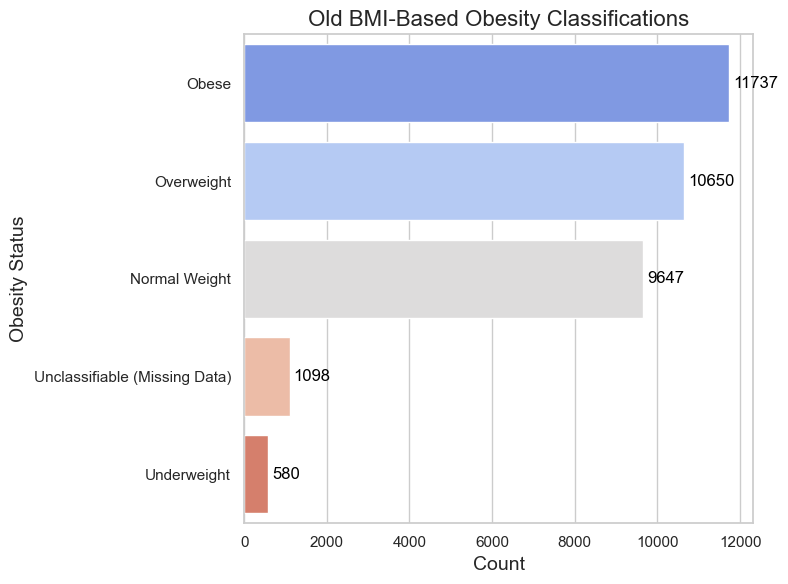

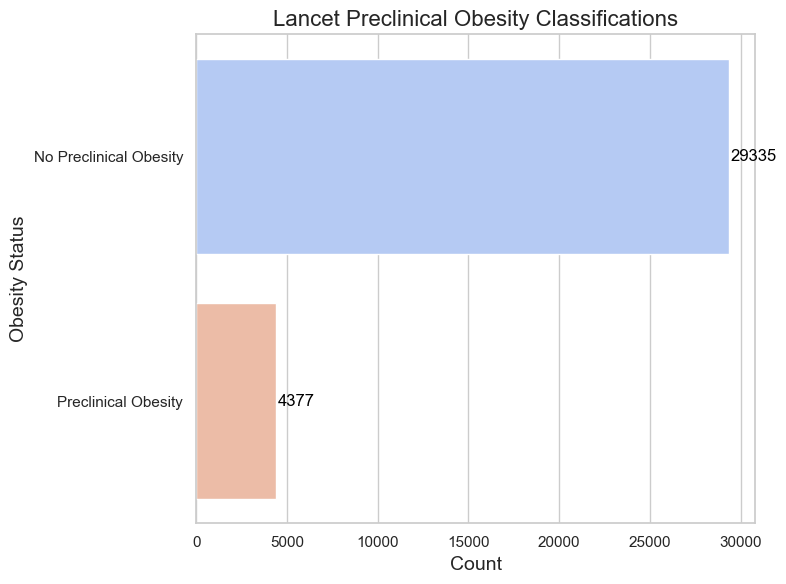

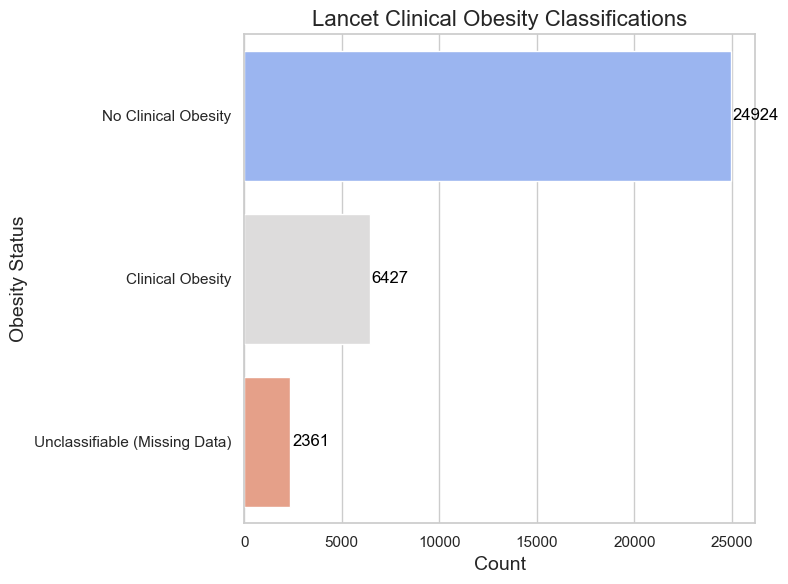

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set visualization style
sns.set(style="whitegrid")

# Define function to add percentage labels
def add_labels(ax):
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 100, p.get_y() + p.get_height()/2, f'{int(width)}', 
                ha='left', va='center', fontsize=12, color='black')

# Plot Old BMI-Based Obesity Status
plt.figure(figsize=(8, 6))
ax = sns.countplot(y="Obesity_Status_Old_BMI", data=filtered_data, 
                   order=filtered_data["Obesity_Status_Old_BMI"].value_counts().index, 
                   palette="coolwarm")

add_labels(ax)
plt.title("Old BMI-Based Obesity Classifications", fontsize=16)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Obesity Status", fontsize=14)
plt.tight_layout()
plt.show()

# Plot Lancet Preclinical Obesity
plt.figure(figsize=(8, 6))
ax = sns.countplot(y="Preclinical_Obesity_Lancet", data=filtered_data, 
                   order=filtered_data["Preclinical_Obesity_Lancet"].value_counts().index, 
                   palette="coolwarm")

add_labels(ax)
plt.title("Lancet Preclinical Obesity Classifications", fontsize=16)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Obesity Status", fontsize=14)
plt.tight_layout()
plt.show()

# Plot Lancet Clinical Obesity
plt.figure(figsize=(8, 6))
ax = sns.countplot(y="Clinical_Obesity_Lancet", data=filtered_data, 
                   order=filtered_data["Clinical_Obesity_Lancet"].value_counts().index, 
                   palette="coolwarm")

add_labels(ax)
plt.title("Lancet Clinical Obesity Classifications", fontsize=16)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Obesity Status", fontsize=14)
plt.tight_layout()
plt.show()

In [5]:
### Save the new clasiifcations

In [6]:
# Save the updated dataset
output_file = "combinedNHANES_with_classifications_Case1.csv"  # Updated filename
filtered_data.to_csv(output_file, index=False)

# Confirm the file has been saved successfully
print(f"Final dataset saved to: {output_file}")

Final dataset saved to: combinedNHANES_with_classifications_Case1.csv


### Debugging Overlaps

In [7]:
# Debugging Chunk: Identifying Overlaps
import pandas as pd

# Identify overlaps where an individual is classified as both Preclinical and Clinical Obesity
overlap_preclinical_clinical = filtered_data[
    (filtered_data["Preclinical_Obesity_Lancet"] == "Preclinical Obesity") &
    (filtered_data["Clinical_Obesity_Lancet"] != "No Clinical Obesity")
].copy()

print("🚨 Overlaps between Preclinical and Clinical Obesity 🚨")
print(overlap_preclinical_clinical[[
    "Participant_ID", "BMI", "Waist", "Gender", 
    "Preclinical_Obesity_Lancet", "Clinical_Obesity_Lancet"
]].dropna(subset=["Preclinical_Obesity_Lancet", "Clinical_Obesity_Lancet"], how="all"))

# Identify cases where BMI is ≥30 but still labeled as Preclinical Obesity
preclinical_with_high_bmi = filtered_data[
    (filtered_data["Preclinical_Obesity_Lancet"] == "Preclinical Obesity") &
    (pd.notnull(filtered_data["BMI"])) & 
    (filtered_data["BMI"] >= 30)
].copy()

print("\n🚨 Preclinical Obesity Cases with BMI ≥ 30 🚨")
print(preclinical_with_high_bmi[[
    "Participant_ID", "BMI", "Waist", "Gender", 
    "Preclinical_Obesity_Lancet", "Clinical_Obesity_Lancet"
]].dropna(subset=["BMI", "Preclinical_Obesity_Lancet"], how="all"))

🚨 Overlaps between Preclinical and Clinical Obesity 🚨
Empty DataFrame
Columns: [Participant_ID, BMI, Waist, Gender, Preclinical_Obesity_Lancet, Clinical_Obesity_Lancet]
Index: []

🚨 Preclinical Obesity Cases with BMI ≥ 30 🚨
       Participant_ID    BMI  Waist  Gender Preclinical_Obesity_Lancet  \
26            31152.0  39.88  130.4     2.0        Preclinical Obesity   
27            31152.0  39.88  130.4     2.0        Preclinical Obesity   
28            31152.0  39.88  130.4     2.0        Preclinical Obesity   
29            31152.0  39.88  130.4     2.0        Preclinical Obesity   
30            31152.0  39.88  130.4     2.0        Preclinical Obesity   
...               ...    ...    ...     ...                        ...   
33623         83583.0  37.40  129.9     1.0        Preclinical Obesity   
33624         83584.0  32.90  105.4     2.0        Preclinical Obesity   
33637         83612.0  30.50  108.0     1.0        Preclinical Obesity   
33677         83672.0  35.70  107.1 

C:\Users\diana.thomas\AppData\Local\Temp\ipykernel_34668\3264736467.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["Lancet_Obesity_Classification"] = filtered_data.apply(


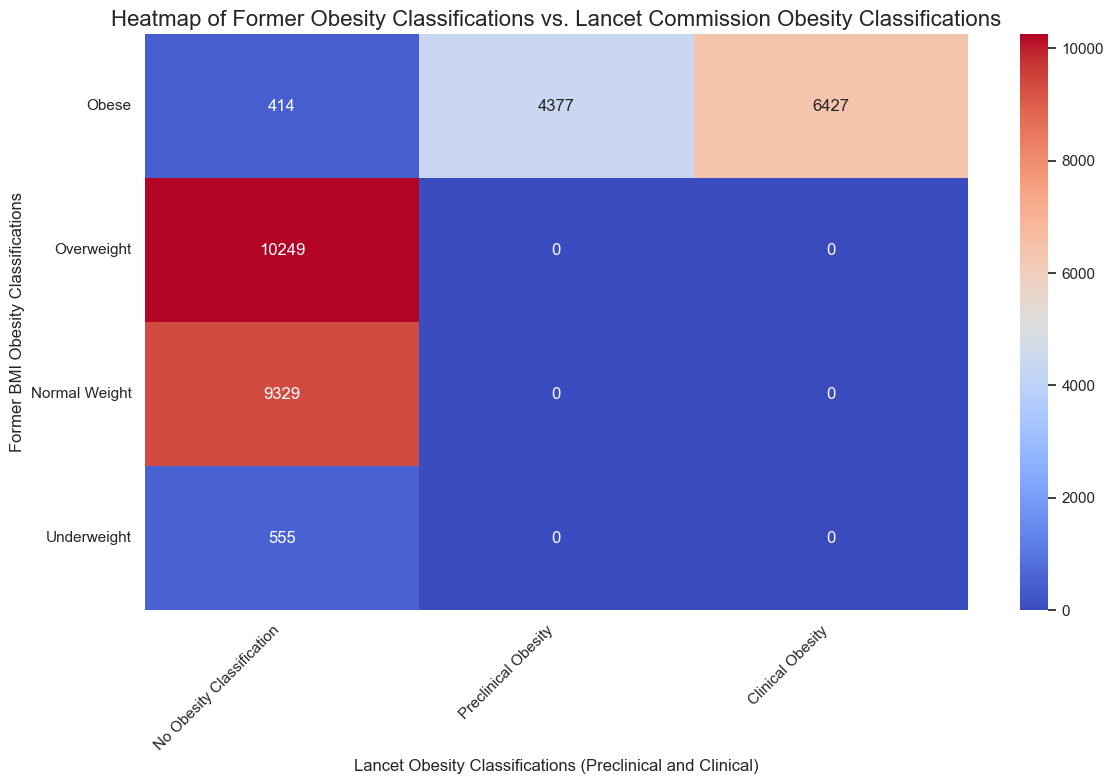

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reload the dataset----------------------------------------------------------------
#############################CHANGE THIS LINE##################################################
file_path  = "combinedNHANES_with_classifications_Case1.csv"  # Updated filename
data = pd.read_csv(file_path)

# Ensure required columns exist
required_columns = ["Obesity_Status_Old_BMI", "Preclinical_Obesity_Lancet", "Clinical_Obesity_Lancet"]
for col in required_columns:
    if col not in data.columns:
        raise ValueError(f"Required column '{col}' is missing from the dataset.")

# Filter out "Unclassifiable (Missing Data)"
filtered_data = data[
    (data["Obesity_Status_Old_BMI"] != "Unclassifiable (Missing Data)") &
    (data["Preclinical_Obesity_Lancet"] != "Unclassifiable (Missing Data)") &
    (data["Clinical_Obesity_Lancet"] != "Unclassifiable (Missing Data)")
]

# Create a **combined classification** column
filtered_data["Lancet_Obesity_Classification"] = filtered_data.apply(
    lambda row: (
        "Clinical Obesity" if row["Clinical_Obesity_Lancet"] == "Clinical Obesity" else
        "Preclinical Obesity" if row["Preclinical_Obesity_Lancet"] == "Preclinical Obesity" else
        "No Obesity Classification"
    ), axis=1
)

# Create contingency table for heatmap
heatmap_data = pd.crosstab(
    filtered_data["Obesity_Status_Old_BMI"], 
    filtered_data["Lancet_Obesity_Classification"], 
    dropna=False
)

# Ensure correct y-axis order (Old BMI categories)
bmi_order = ["Underweight", "Normal Weight", "Overweight", "Obese"]
heatmap_data = heatmap_data.reindex(bmi_order[::-1])  # Reverse order (Underweight at bottom)

# Ensure correct x-axis order (Lancet Obesity classifications)
column_order = [
    "No Obesity Classification",
    "Preclinical Obesity",
    "Clinical Obesity"
]

heatmap_data = heatmap_data[column_order]  # Reorder columns

# Plot the heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="coolwarm", cbar=True)

# Rotate x-axis labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Update plot labels
plt.title("Heatmap of Former Obesity Classifications vs. Lancet Commission Obesity Classifications-Case 1", fontsize=16)
plt.xlabel("Lancet Obesity Classifications (Preclinical and Clinical)", fontsize=12)
plt.ylabel("Former BMI Obesity Classifications", fontsize=12)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [9]:
import pandas as pd

# Load the dataset
##################################CHANGE THIS LINE$#############################
file_path = "combinedNHANES_with_classifications_Case1.csv"  # Ensure this file exists in the working directory
data = pd.read_csv(file_path)

# Filter for underweight individuals who were classified as preclinical obesity
underweight_preclinical = data[
    (data["Obesity_Status_Old_BMI"] == "Underweight") &
    (data["Preclinical_Obesity_Lancet"] == "Preclinical Obesity")
]

# Display the number of such individuals and relevant columns
print("Number of Underweight individuals classified as Preclinical Obesity:", len(underweight_preclinical))
print(underweight_preclinical[[
    "Participant_ID", "BMI", "Waist", "Gender", "Preclinical_Obesity_Lancet", "Clinical_Obesity_Lancet"
]])

# Save for further inspection
underweight_preclinical.to_csv("debug_underweight_preclinical.csv", index=False)
print("Filtered data saved as debug_underweight_preclinical.csv")


Number of Underweight individuals classified as Preclinical Obesity: 0
Empty DataFrame
Columns: [Participant_ID, BMI, Waist, Gender, Preclinical_Obesity_Lancet, Clinical_Obesity_Lancet]
Index: []
Filtered data saved as debug_underweight_preclinical.csv


### This makes the heat map for %fat for Case 1

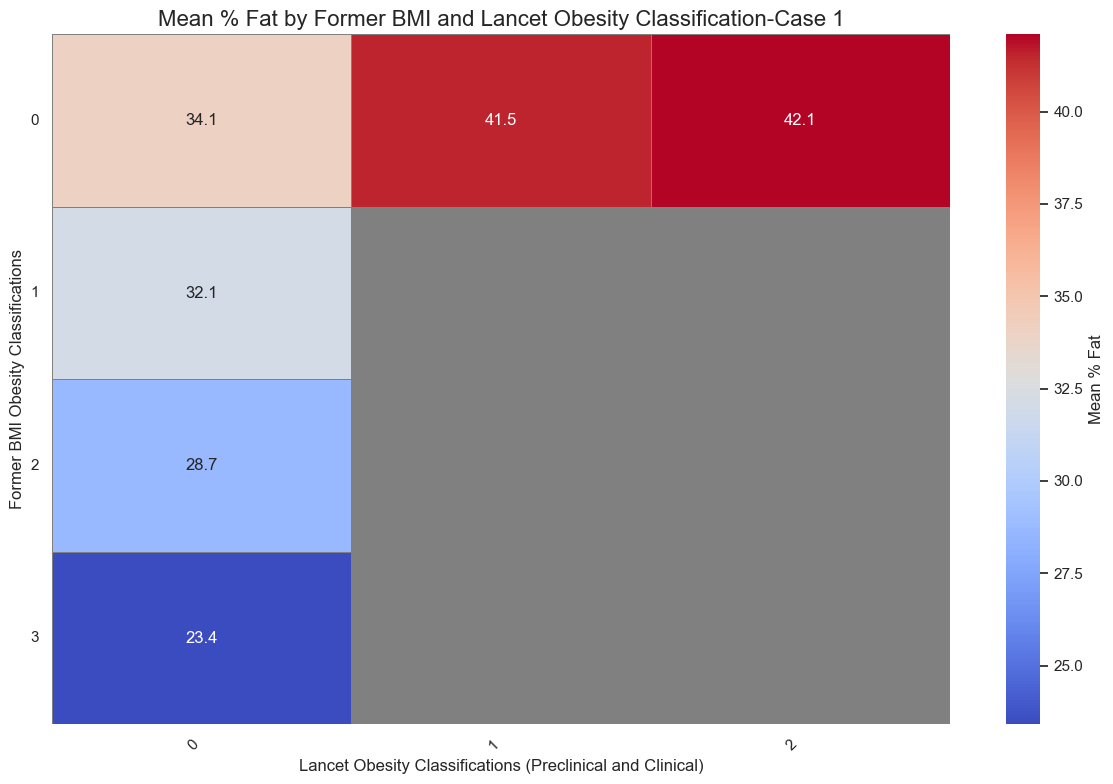

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Ensure the dataset is loaded
file_path = "combinedNHANES_with_classifications_Case1.csv"
data = pd.read_csv(file_path)

# Ensure Lancet_Obesity_Classification is defined
data["Lancet_Obesity_Classification"] = data.apply(
    lambda row: (
        "Clinical Obesity" if row["Clinical_Obesity_Lancet"] == "Clinical Obesity" else
        "Preclinical Obesity" if row["Preclinical_Obesity_Lancet"] == "Preclinical Obesity" else
        "No Obesity Classification"
    ), axis=1
)

# Ensure required columns exist **after creating the necessary classification column**
required_columns = ["Obesity_Status_Old_BMI", "Lancet_Obesity_Classification", "Percent_Fat"]
for col in required_columns:
    if col not in data.columns:
        raise ValueError(f"Required column '{col}' is missing from the dataset.")

# Filter out missing values for percent fat
filtered_data = data.dropna(subset=["Percent_Fat"])

# Create pivot table for mean % fat
heatmap_data = filtered_data.pivot_table(
    index="Obesity_Status_Old_BMI",
    columns="Lancet_Obesity_Classification",
    values="Percent_Fat",
    aggfunc=np.mean
)

# Create a count table to identify categories with zero individuals
count_data = data.pivot_table(
    index="Obesity_Status_Old_BMI",
    columns="Lancet_Obesity_Classification",
    values="Percent_Fat",
    aggfunc="count"
)

# Ensure correct y-axis order (Old BMI categories)
bmi_order = ["Underweight", "Normal Weight", "Overweight", "Obese"]
heatmap_data = heatmap_data.reindex(bmi_order[::-1])  # Reverse order (Underweight at bottom)
count_data = count_data.reindex(bmi_order[::-1])

# Ensure correct x-axis order (Lancet Obesity classifications)
column_order = ["No Obesity Classification", "Preclinical Obesity", "Clinical Obesity"]
heatmap_data = heatmap_data[column_order]  # Reorder columns
count_data = count_data[column_order]

# Create a mask where count_data == 0 (i.e., no individuals in that category)
zero_individuals_mask = count_data == 0

# Define a new colormap: Use 'coolwarm' for valid data, and explicitly set NaN (zero individuals) to grey
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap.set_bad("grey")  # Ensures missing values (zero individuals) appear grey

# Convert heatmap_data into a masked array
masked_heatmap_data = np.ma.masked_where(zero_individuals_mask, heatmap_data)

# Plot heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    masked_heatmap_data, annot=True, fmt=".1f", cmap=cmap, cbar=True,
    linewidths=0.5, linecolor='grey',
    vmin=np.nanmin(heatmap_data), vmax=np.nanmax(heatmap_data),  # Keep scale consistent
    cbar_kws={"label": "Mean % Fat"}
)

# Rotate x-axis labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Update plot labels
###############################Change to Case X for each Case######################################
plt.title("Mean % Fat by Former BMI and Lancet Obesity Classification-Case 1", fontsize=16)
plt.xlabel("Lancet Obesity Classifications (Preclinical and Clinical)", fontsize=12)
plt.ylabel("Former BMI Obesity Classifications", fontsize=12)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()